In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K


Using TensorFlow backend.


In [2]:
#two channels, do k-bit, M-ary generalisation. starting with k=4 for 16 symbols
n = 2
k = 6
M = 2**k
R = k/n
channel_noise_dB=16
channel_noise_ratio = 10**(channel_noise_dB/10)
PD_noise_dB=16
PD_noise_ratio = 10**(PD_noise_dB/10)
CD_noise_dB=16
CD_noise_ratio = 10**(CD_noise_dB/10)
noise_mag1 = 1#np.sqrt(1/(2*R*channel_noise_ratio))
PDnoise_mag = 1#np.sqrt(1/(2*R*PD_noise_ratio))
CDnoise_mag = 1#np.sqrt(1/(2*R*CD_noise_ratio))
print('channel:',noise_mag1)
print('processing:',PDnoise_mag)
P=400

channel: 1
processing: 1


In [3]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])

verification checks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
#Custom layer definition
class EnergySplitter(keras.layers.Layer):
  '''
  Creates two copies of the input, concatenated onto one dimension, each 
  multiplied by a constant. The parameter rho is trainable.
  The first copy of the input is multiplied by sqrt(1-rho), while the second is
  multiplied by sqrt(rho).
  '''
  def compute_output_shape(self,input_shape):
    return [input_shape,input_shape]
  
  def __init__(self,**kwargs):
    super(EnergySplitter,self).__init__(**kwargs)
    #initialise the splitting ratio
    self.rho=tf.Variable(
        initial_value=0.9,
        trainable=True,
        constraint=lambda t: tf.clip_by_value(t,0,0.999)
    )

  def call(self,inputs):
    return [K.sqrt(1-self.rho)*inputs,K.sqrt(self.rho)*inputs]

class SquareSum(keras.layers.Layer):
  '''
  returns a scalar value, the sum of the elementwise squared input
  '''
  def compute_output_shape(self, input_shape):
    return (None,1)
  
  def __init__(self, **kwargs):
    super(SquareSum,self).__init__(**kwargs)
  
  def call(self, inputs):
    return K.reshape(tf.convert_to_tensor([K.sum(K.square(inputs),axis=1)],dtype='float32'),shape=(tf.shape(inputs)[0],1))

#coord_dict = {
#    (1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) : (3,3),
#    (0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0) : (1,3),
#    (0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0) : (3,1),
#    (0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0) : (1,1),
#    (0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0) : (-3,3),
#    (0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0) : (-1,3),
#    (0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0) : (-3,1),
#    (0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0) : (-1,1),
#    (0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0) : (3,-3),
#    (0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0) : (1,-3),
#    (0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0) : (3,-1),
#    (0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0) : (1,-1),
#    (0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0) : (-3,-3),
#    (0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0) : (-1,-3),
#    (0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0) : (-3,-1),
#    (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1) : (-1,-1),
#    }
#
#@tf.function
#def map_function(inputs):
#  return tf.map_fn(lambda x: tf.py_function(readDict,[x],[tf.float32,tf.float32]),inputs,dtype=[tf.float32,tf.float32],parallel_iterations=1600)
#
#def readDict(x):
#    return coord_dict[tuple(K.eval(x))]
#
#class RectMod16_old(keras.layers.Layer):
#  '''
#  takes a 1-hot class vector as an input, outputs the corresponding rectangular 
#  16-QAM baseband values
#
#  This version uses dictionaries and is super inefficient. New version is much faster
#  '''
#  def compute_output_shape(self,input_shape):
#    return (input_shape[0],2)
#  
#  def __init__(self, **kwargs):
#    super(RectMod16_old,self).__init__(**kwargs)
#
#  def call(self, inputs):
#    return K.reshape(tf.transpose(tf.convert_to_tensor(map_function(inputs))),shape=(tf.shape(inputs)[0],2))
#    #Old solution: tf.convert_to_tensor(tf.map_fn(lambda x: coord_dict[tuple(K.eval(x))],inputs))
#    #This works if called directly on an input, but fails graph creation because
#    #list comprehension is unsupported
#
#    #A solution with list comprehension was throwing an error, solution found at
#    # https://github.com/tensorflow/tensorflow/issues/32546
#    #This also didn't work: 
#    #temp=tf.TensorArray(inputs.dtype,size=0,dynamic_size=True)
#    #for x in inputs:
#    #  temp = temp.write(temp.size(), coord_dict[tuple(K.eval(x))])
#    #return temp.stack()
#    #When using a mapping like a dictionary, it returns a non-eager Tensor

class RectMod64(keras.layers.Layer):
  '''
  takes a 1-hot class vector as an input, outputs the corresponding rectangular 
  16-QAM baseband values, using keras operations
  '''
  def compute_output_shape(self,input_shape):
    return (input_shape[0],2)
  
  def __init__(self, **kwargs):
    super(RectMod64,self).__init__(**kwargs)
    self.coords_tensor=coords_tensor = tf.cast(tf.convert_to_tensor(
        [(-7, 7),(-7, 5),(-7, 1),(-7, 3),(-7, -7),(-7, -5),(-7, -1),(-7, -3),(-5, 7),(-5, 5),(-5, 1),(-5, 3),(-5, -7),(-5, -5),(-5, -1),(-5, -3),(-1, 7),
         (-1, 5),(-1, 1),(-1, 3),(-1, -7),(-1, -5),(-1, -1),(-1, -3),(-3, 7),(-3, 5),(-3, 1),(-3, 3),(-3, -7),(-3, -5),(-3, -1),(-3, -3),(7, 7),(7, 5),
         (7, 1),(7, 3),(7, -7),(7, -5),(7, -1),(7, -3),(5, 7),(5, 5),(5, 1),(5, 3),(5, -7),(5, -5),(5, -1),(5, -3),(1, 7),(1, 5),(1, 1),(1, 3),(1, -7),
         (1, -5),(1, -1),(1, -3),(3, 7),(3, 5),(3, 1),(3, 3),(3, -7),(3, -5),(3, -1),(3, -3),]
        ),dtype=tf.float32)

  def call(self,inputs):
    return tf.tensordot(inputs,self.coords_tensor,axes=1)
    #multiply by coords tensor

In [8]:
#Build the model:

#input
autoenc_in = keras.layers.Input(shape=(M,))

#encoder
encoder = RectMod64()(autoenc_in)

#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False)(encoder)

#Transmit power
boost= keras.layers.Lambda(lambda x: x*np.sqrt(P))(regulariser)

#Channel noise
channel = keras.layers.GaussianNoise(noise_mag1)(boost)

#Splitter
splitter_layer = EnergySplitter(name='Splitter')
splitter = splitter_layer(channel)
PD_in = tf.identity(splitter[0])
CD_in = tf.identity(splitter[1])

#PD processing
presquaring = SquareSum()(PD_in)
PD_noise = keras.layers.GaussianNoise(PDnoise_mag,name='PD_noise')(presquaring)
PD_deboost = keras.layers.Lambda(lambda x: x/P)(PD_noise)

#CD processing
CD_noise = keras.layers.GaussianNoise(CDnoise_mag,name='CD_noise')(CD_in)
CD_deboost = keras.layers.Lambda(lambda x: x/np.sqrt(P))(CD_noise)

#Try adding pre-processing to do something with each pathway before merging
PD_preproc = keras.layers.Dense(M,activation='relu')(PD_deboost)
CD_preproc = keras.layers.Dense(M,activation='relu')(CD_deboost)

#Merge two inputs
Merge = keras.layers.Concatenate(axis=-1,name='Merge')([PD_preproc,CD_preproc])

#decoder
decoder_0 = keras.layers.Dense(2*M,activation='relu')(Merge)
decoder_ins= keras.layers.Dense(M,activation='relu')(decoder_0)
decoder_1 = keras.layers.Dense(M,activation='softmax')(decoder_ins)

#Put it together
autoencoder = keras.models.Model(autoenc_in,decoder_1)
print(autoencoder.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
rect_mod64_2 (RectMod64)        (None, 2)            0           input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           rect_mod64_2[0][0]               
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [0]:
#keras.utils.plot_model(
#    autoencoder,
#    to_file='modelmap.png'
#)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.0008)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [14]:
autoencoder.fit(xs,xs,batch_size=M*100,epochs=60)

Epoch 1/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0106
Epoch 2/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0103
Epoch 3/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0104
Epoch 4/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0104
Epoch 5/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0099
Epoch 6/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0102
Epoch 7/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0100
Epoch 8/60
100/100 [==============================] - 3s 34ms/step - loss: 0.0100
Epoch 9/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0101
Epoch 10/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0091
Epoch 11/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0097
Epoch 12/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0091
Epoch 13/60
1

In [0]:
#Make subordinate models for plotting/simulation
encoder = keras.models.Model(autoenc_in,regulariser)

#Make the decoder from the concatenation onwards: 
#deco_in = [keras.layers.Input(shape=(1,)),keras.layers.Input(shape=(2,))]
#with inserted decoder layers:
deco_PD_in = keras.layers.Input(shape=(1,))
deco_CD_in = keras.layers.Input(shape=(2,))
#deco_PD = autoencoder.layers[-8](deco_PD_in)
#deco_CD = autoencoder.layers[-7](deco_CD_in)
deco_PD = autoencoder.layers[-6](deco_PD_in)
deco_CD = autoencoder.layers[-5](deco_CD_in)
deco = autoencoder.layers[-4]([deco_PD,deco_CD])
#else (modify input without insert)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = keras.models.Model([deco_PD_in,deco_CD_in],deco)

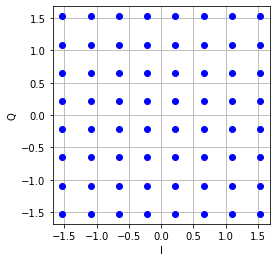

rho = 0.878741
PD proportion = 0.3482225927123589
CD proportion = 0.9374119


In [15]:
#Plot modulation scheme
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()
rho=splitter_layer.get_weights()[0]
print('rho =',rho)
print('PD proportion =',np.sqrt(1-rho))
print('CD proportion =',np.sqrt(rho))

In [17]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use/n)
print('scaling, should be around 1, =',scaling)

2.0018134222452866
scaling, should be around 1, = 1.000453252842252


In [0]:
'''
# Monte-Carlo Modelling
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(0,16,1.5))
EbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])
EbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])
ser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))
for iter1 in range(len(EbNo_range_dB_channel)):
  for iter2 in range(len(EbNo_range_dB_PD)):
    for iter3 in range(len(EbNo_range_dB_CD)):
      # Create channel noise vector
      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)
      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
      noise_channel = noise_std_channel*np.random.randn(dat_size,n)
      # Create PD noise vector
      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)
      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling
      noise_PD = noise_std_PD*np.random.randn(dat_size)
      # Create CD noise vector
      EbNo_CD = 10**(EbNo_range_dB_CD[iter3]/10)
      noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
      noise_CD = noise_std_CD*np.random.randn(dat_size,n)
      # Get encoder output and add channel noise
      channel_out=encoder.predict(xs)+noise_channel
      # PD section
      PD_input = channel_out*np.sqrt(1-rho)
      PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
      PD_out = PD_squared+noise_PD
      # CD section, literally just add more noise to scaled input
      CD_out = channel_out*np.sqrt(rho)+noise_CD
      # Prediction based on noises
      prediction = decoder.predict([PD_out,CD_out])
      prediction = np.argmax(prediction,axis=1)
      wrong = (prediction != rand_data)
      count=np.sum(wrong)
      index=iter3+len(EbNo_range_dB_CD)*iter2+len(EbNo_range_dB_CD)*len(EbNo_range_dB_PD)*iter1
      ser[index]=count/dat_size
      print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_range_dB_PD[iter2],'| CD EbNo(dB):',EbNo_range_dB_CD[iter3],'| SER',ser[index])
'''

In [0]:
dat_size=M*5000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)

In [31]:
# Monte-Carlo Modelling for processing noise consistent relative to channel noise
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
P_dB = list(np.arange(20,28,1))
EbNo_dB_PD_diff = PD_noise_dB - channel_noise_dB
EbNo_dB_CD_diff = CD_noise_dB - channel_noise_dB
ser = [None]*len(P_dB)
for iter1 in range(len(P_dB)):
  # Create channel noise vector
  P=10**(P_dB[iter1]/10)
  #EbNo_channel_dB=EbNo_range_dB_channel[iter1]
  #EbNo_channel = 10**(EbNo_channel_dB/10)
  #noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
  noise_channel = np.random.randn(dat_size,n)#*noise_std_channel
  # Create PD noise vector
  #EbNo_PD = 10**((EbNo_dB_PD_diff+EbNo_channel_dB)/10)
  #noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling
  noise_PD = np.random.randn(dat_size)#*noise_std_PD
  # Create CD noise vector
  #EbNo_CD = 10**((EbNo_dB_CD_diff+EbNo_channel_dB)/10)
  #noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
  noise_CD = np.random.randn(dat_size,n)#*noise_std_CD
  # Get encoder output and add channel noise
  channel_out=encoder.predict(xs)*np.sqrt(P)+noise_channel
  # PD section
  PD_input = channel_out*np.sqrt(1-rho)
  PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
  PD_out = (PD_squared+noise_PD)/P
  # CD section, literally just add more noise to scaled input
  CD_out = (channel_out*np.sqrt(rho)+noise_CD)/np.sqrt(P)
  # Prediction based on noises
  prediction = decoder.predict([PD_out,CD_out])
  prediction = np.argmax(prediction,axis=1)
  wrong = (prediction != rand_data)
  count=np.sum(wrong)
  ser[iter1]=count/dat_size
  print('P(dB)=',10*np.log10(P),'| SER',ser[iter1])

P(dB)= 20.0 | SER 0.1545
P(dB)= 21.0 | SER 0.099753125
P(dB)= 22.0 | SER 0.059040625
P(dB)= 23.0 | SER 0.031575
P(dB)= 24.0 | SER 0.0143
P(dB)= 25.0 | SER 0.005890625
P(dB)= 26.0 | SER 0.002034375
P(dB)= 27.0 | SER 0.00050625


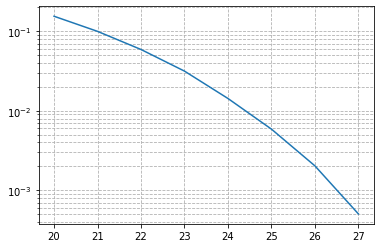

In [35]:
# sandbox
plt.plot(P_dB,ser)
plt.yscale('log')
plt.grid(which='both',linestyle='--')
